In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
from sklearn import datasets

In [4]:
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target_names[iris.target]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [24]:
def make_demographic(df, group_col, **kwargs):
    """
    stackしたデータから独立な2群(group_col)に分けてdemographic dataを作成する
    **kwargs:比較したい性別や年齢などを指定。変数名="c" or "m" のモードに対応
    LR="c", sex="c", age="m"のように指定し、モードcは**％(**/**)、mは平均±SDを出力
    """
    res_df = pd.DataFrame(columns=kwargs.keys())
    for param, func in kwargs.items():
        if func == "c":
            piv = pd.crosstab(df[param], df[group_col], margins=True)
            x2, p, dof, e = st.chi2_contingency(piv, correction=False)
            
            rates = [round(piv.iloc[0, i] / piv.iloc[2, i] * 100, 1) for i in range(2)]
            row = {}
            for i in range(2):
                row[piv.columns[i]] = "{0}%({1}/{2})".format(rates[i], piv.iloc[0, i], piv.iloc[2, i])
            row["p value"] = p.round(2) if p >= 0.01 else "p<0.01"
            res_df[param] = pd.Series(row)
            
        elif func == "m":
            piv = df.pivot_table(values=param, columns=group_col, aggfunc=["mean", "std"])
            means = [round(piv.iloc[0, i], 1) for i in range(2)]
            stds = [round(piv.iloc[0, i+2], 1) for i in range(2)]
            
            row = {}
            for i in range(2):
                row[piv.columns[i][1]] = "{0}±{1}".format(means[i], stds[i])
            A = [df[df[group_col]==piv.columns[i][1]][param] for i in range(2)]
            p = st.ttest_ind(*A, equal_var=False).pvalue
            row["p value"] = p.round(2) if p >= 0.01 else "p<0.01"
            res_df[param] = pd.Series(row)
        
    return res_df.T

In [22]:
df.describe(include="all")

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,virginica
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.057333,3.758000,1.199333,NaN
std,0.828066,0.435866,1.765298,0.762238,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


In [27]:
dic = {"sepal length (cm)":"m", "sepal width (cm)": "m"}
tmp_df = df.query("target!='setosa'")
make_demographic(tmp_df, "target", **dic)

,versicolor,virginica,p value
sepal length (cm),5.9±0.5,6.6±0.6,p<0.01
sepal width (cm),2.8±0.3,3.0±0.3,p<0.01


In [1]:
# Tukeyの多重比較結果をシンプルなDataFrameに変換する
def Tukey_to_dataframe(df):
    columns = ["group1", "group2", "meandiff", "p", "lower", "upper", "reject"]
    df = df.iloc[1:,].reset_index()
    df.columns = columns
    return df

In [4]:
# Bland-Altman analysis
df = pd.read_csv("data/data2.csv", encoding="shift-jis")
df.columns

Index(['ID', 'name', 'sex', 'age', 'baPWV', 'R)filename', 'L)filename',
       'R) 予測全体baPWV', 'L) 予測全体baPWV', 'R) 予測周囲baPWV', 'L) 予測周囲baPWV',
       'R) 予測中心baPWV', 'L) 予測中心baPWV'],
      dtype='object')

In [18]:
R_col_names = {"Total": "R) 予測全体baPWV", "Peripheral": "R) 予測周囲baPWV", "Central": "R) 予測中心baPWV"}
L_col_names = {"Total": "L) 予測全体baPWV", "Peripheral": "L) 予測周囲baPWV", "Central": "L) 予測中心baPWV"}

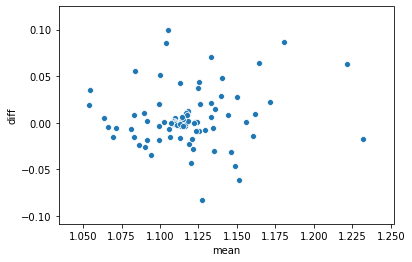

In [29]:
areas = ["Total", "Peripheral", "Central"]

area = areas[0]
col1 = R_col_names[area]
col2 = L_col_names[area]
res_df = df[[col1, col2]].copy()
res_df["mean"] = (res_df[col1] + res_df[col2]) / 2
res_df["diff"] = res_df[col1] - res_df[col2] # col1 - col2

sns.scatterplot(data=res_df, x="mean", y="diff")

In [217]:
import math
import pandas as pd
import scipy.stats as st

class Bland_Altman:
    
    def __init__(self, df, col1, col2, alpha=0.05):
        
        self.df = df.copy()
        self.col1 = col1
        self.col2 = col2
        self.n = len(self.df[col1])
        self.alpha = alpha
        self.z_a = st.norm.ppf(1-alpha)
        self.t_a = st.t.ppf(df=self.n-1, q=1-alpha) # 自由度nのt分布の(1-α)％点
        self.df["mean"] = (self.df[col1] + self.df[col2]) / 2
        self.df["diff"] = self.df[col1] - self.df[col2] # col1 - col2
        self.df["r_diff"] = self.df["diff"] * 100 / self.df["mean"]

        
    def result(self, is_relative=False):
        diff_col = "diff"
        if is_relative:
            diff_col = "r_diff"
        
        print("Bland-Altman plot")
        
        r, p, corr_low, corr_up = self.get_corr("mean", diff_col, self.alpha)
        
        r, corr_low, corr_up= round(r,3), round(corr_low,3), round(corr_up, 3)
        is_prop_bias = p < self.alpha
        p = "<0.01" if p < 0.01 else round(p,3)

        print(f"相関係数：{r}[{corr_low}-{corr_up}] p {p}")
        print(f"比例誤差：{is_prop_bias}")
        self.plot(is_relative)

    
    def plot(self, is_relative=False):
        diff_col = "diff"
        if is_relative:
            diff_col = "r_diff"
        
        LOA_up = self.df[diff_col].mean() + self.z_a * self.df[diff_col].std()
        LOA_low = self.df[diff_col].mean() - self.z_a * self.df[diff_col].std()
        LOA_conf = self.t_a * math.sqrt(3 * self.df[diff_col].std()**2 / self.n)
        
        sns.scatterplot(data=self.df, x="mean", y=diff_col, color="blue")
        
        #平均
        plt.axhline(self.df[diff_col].mean(), color='black', linestyle="--")
        
        #上側LOA
        plt.axhline(LOA_up, color='black', linestyle="--")
        #上側LOAの信頼区間
        plt.axhline(LOA_up + LOA_conf, color='gray', linestyle=':')
        plt.axhline(LOA_up - LOA_conf, color='gray', linestyle=':')
        
        #下側LOA
        plt.axhline(LOA_low, color='black', linestyle="--")
        #下側LOAの信頼区間
        plt.axhline(LOA_low + LOA_conf, color='gray', linestyle=':')
        plt.axhline(LOA_low - LOA_conf, color='gray', linestyle=':')
        
        plt.xlabel("Mean")
        plt.ylabel("Difference")
        
        plt.savefig("data/Bland-Altman.tiff", format="tiff", dpi=300)
        
        plt.show()
    
    def describe(self):
        return self.df[[self.col1, self.col2, "mean", "diff", "r_diff"]].describe()

    def has_proportional_bias(self):
        r, p, (corr_low, corr_up) = self.get_corr("mean", "diff", self.alpha)
        return p < self.alpha

    def get_corr(self, col1, col2, alpha=0.05):
        a, b = self.df[col1], self.df[col2]        
        r, p = st.pearsonr(a, b)
        n = len(a)
        z= 0.5 * math.log((1+r)/(1-r))
        za = st.norm.ppf(1-alpha)
        zl = z - za * math.sqrt(1/(n-3))
        zu = z + za * math.sqrt(1/(n-3))
        rhol = (math.exp(2 * zl) - 1 )/ (math.exp(2 * zl) +1 )
        rhou = (math.exp(2 * zu) - 1 )/ (math.exp(2 * zu) +1 )
        return r, p, rhol, rhou
        

Central
       Actual baPWV  Predicted baPWV       mean       diff     r_diff
count     85.000000        85.000000  85.000000  85.000000  85.000000
mean       1.136824         1.140491   1.138657  -0.003667  -0.560771
std        0.091394         0.044473   0.056713   0.088295   7.589713
min        0.990000         1.054123   1.042061  -0.153285 -13.851356
25%        1.060000         1.118040   1.093738  -0.072307  -6.478214
50%        1.130000         1.125644   1.132353  -0.014954  -1.350245
75%        1.200000         1.152307   1.182663   0.053548   4.622980
max        1.380000         1.284812   1.315517   0.206286  16.155748
Bland-Altman plot
相関係数：0.637[0.516-0.732] p <0.01
比例誤差：True


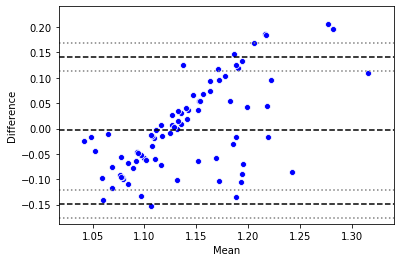

In [220]:
df = pd.read_csv("data/data2.csv", encoding="shift-jis").rename(columns={"baPWV": "Actual baPWV"})
areas = ["Total", "Peripheral", "Central"]

for area in areas[2:3]:
    print(area)
    
    R_col = R_col_names[area]
    L_col = L_col_names[area]
    true_col = "Actual baPWV"
    pred_col = "Predicted baPWV"
    ba_df = df[[true_col, R_col, L_col]].copy()
    # 予測値はLとRのうち大きいほうを採用
    ba_df[pred_col] = ba_df.apply(lambda x: max(x[L_col], x[R_col]), axis=1)

    BA = Bland_Altman(ba_df, true_col, pred_col)
    print(BA.describe())
    BA.result(False)


Bland-Altman plot
平均：0.009041373764486937
上側95.0%LOA：          0.146[0.12~0.171]
下側95.0%LOA：          -0.127[-0.153~-0.102]
相関係数：0.775[0.692~0.838] p <0.01
比例誤差：True
Bland-Altman plot
平均：-0.0036671915682623883
上側95.0%LOA：          0.142[0.114~0.169]
下側95.0%LOA：          -0.149[-0.176~-0.121]
相関係数：0.637[0.516~0.732] p <0.01
比例誤差：True
Bland-Altman plot
平均：-0.009576887337179655
上側95.0%LOA：          0.132[0.105~0.158]
下側95.0%LOA：          -0.151[-0.178~-0.124]
相関係数：0.534[0.392~0.651] p <0.01
比例誤差：True


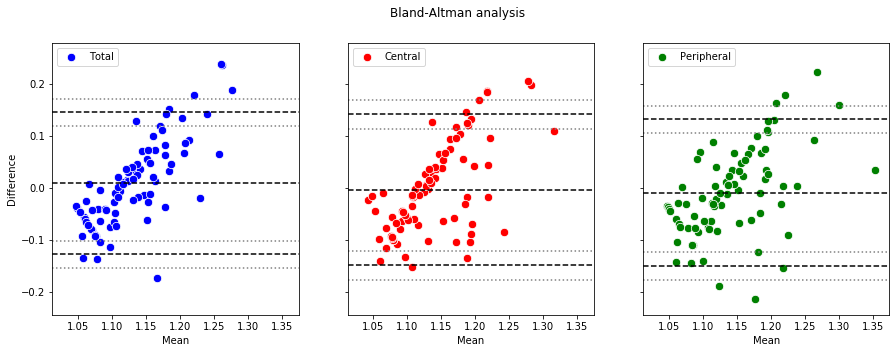

In [283]:
df = pd.read_csv("data/data2.csv", encoding="shift-jis").rename(columns={"baPWV": "Actual baPWV"})
true_col = "Actual baPWV"
pred_col = "Predicted baPWV"

areas = ["Total", "Central", "Peripheral"]
mark_colors = ["blue", "red", "green"]

f, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))


for i, area in enumerate(areas):
    R_col = R_col_names[area]
    L_col = L_col_names[area]
    ba_df = df[[true_col, R_col, L_col]].copy()
    # 予測値はLとRのうち大きいほうを採用
    ba_df[pred_col] = ba_df.apply(lambda x: max(x[L_col], x[R_col]), axis=1)
    # 前処理
    ba_df = Bland_Altman_init(ba_df[[true_col, pred_col]], true_col, pred_col)

    # 各種設定項目
    diff_col = "diff"

    mark_color = mark_colors[i]
    mean_color = "black"
    LOA_color = "black"
    conf_color = "gray"

    # 各種統計計算値
    n = len(ba_df[true_col])
    alpha = 0.05
    z_a = st.norm.ppf(1-alpha)
    t_a = st.t.ppf(df=n-1, q=1-alpha) # 自由度nのt分布の(1-α)％点
    LOA_up = ba_df[diff_col].mean() + z_a * ba_df[diff_col].std()
    LOA_low = ba_df[diff_col].mean() - z_a * ba_df[diff_col].std()
    LOA_conf = t_a * math.sqrt(3 * ba_df[diff_col].std()**2 / n)


    # 描画
    ax = axes[i]
    sns.scatterplot(data=ba_df, x="mean", y=diff_col, s=70, color=mark_color, ax=ax, label=area)
    ax.legend(loc="upper left")
    #平均
    ax.axhline(ba_df[diff_col].mean(), color=mean_color, linestyle="--")

    #上側LOA
    ax.axhline(LOA_up, color=LOA_color, linestyle="--")
    #上側LOAの信頼区間
    ax.axhline(LOA_up + LOA_conf, color=conf_color, linestyle=':')
    ax.axhline(LOA_up - LOA_conf, color=conf_color, linestyle=':')

    #下側LOA
    ax.axhline(LOA_low, color=LOA_color, linestyle="--")
    #下側LOAの信頼区間
    ax.axhline(LOA_low + LOA_conf, color=conf_color, linestyle=':')
    ax.axhline(LOA_low - LOA_conf, color=conf_color, linestyle=':')

    ax.set_xlabel("Mean")
    ax.set_ylabel("Difference")
    
    Bland_Altman_result(ba_df)



plt.suptitle("Bland-Altman analysis")

#plt.savefig("data/Bland-Altman.tiff", format="tiff", dpi=300)

plt.show()

In [317]:
import math
import pandas as pd
import seaborn as sns
import scipy.stats as st

def Bland_Altman_init(df, col1, col2, alpha=0.05):

    df = df.copy()
    df["mean"] = (df[col1] + df[col2]) / 2
    df["diff"] = df[col1] - df[col2] # col1 - col2
    df["r_diff"] = df["diff"] * 100 / df["mean"]
    
    return df

def Bland_Altman_result(df, alpha=0.05, is_relative=False):
    diff_col = "diff"
    if is_relative:
        diff_col = "r_diff"

    print("Bland-Altman plot")

    z_a = st.norm.ppf(1-alpha)
    t_a = st.t.ppf(df=n-1, q=1-alpha) # 自由度nのt分布の(1-α)％点
    LOA_up = df[diff_col].mean() + z_a * df[diff_col].std()
    LOA_low = df[diff_col].mean() - z_a * df[diff_col].std()
    LOA_conf = t_a * math.sqrt(3 * df[diff_col].std()**2 / n)
    
    r, p, corr_low, corr_up = get_corr(df, "mean", diff_col, alpha)

    r, corr_low, corr_up= round(r,3), round(corr_low,3), round(corr_up, 3)
    is_add_bias = not(LOA_low + LOA_conf < 0 < LOA_up - LOA_conf)
    is_prop_bias = p < alpha
    p = "<0.01" if p < 0.01 else round(p,3)

    print(f"平均：{df[diff_col].mean()}")
    print(f"上側{100-alpha*100}%LOA：\
          {round(LOA_up,3)}[{round(LOA_up-LOA_conf,3)}~{round(LOA_up+LOA_conf,3)}]")
    print(f"下側{100-alpha*100}%LOA：\
          {round(LOA_low,3)}[{round(LOA_low-LOA_conf,3)}~{round(LOA_low+LOA_conf,3)}]")
    print(f"相関係数：{r}[{corr_low}~{corr_up}] p {p}")
    print(f"加算誤差：{is_add_bias}")
    print(f"比例誤差：{is_prop_bias}")


def Bland_Altman_plot(ba_df, true_col, pred_col, mark_color, ax, is_relative=False):
    """
    df: Bland_Altman_initで返ってきたdfを入れる
    ax: subplot用
    """
    
    # 各種設定項目
    diff_col = "r_diff" if is_relative else "diff"

    mean_color = "black"
    LOA_color = "black"
    conf_color = "gray"

    # 各種統計計算値
    n = len(ba_df[true_col])
    alpha = 0.05
    z_a = st.norm.ppf(1-alpha)
    t_a = st.t.ppf(df=n-1, q=1-alpha) # 自由度nのt分布の(1-α)％点
    LOA_up = ba_df[diff_col].mean() + z_a * ba_df[diff_col].std()
    LOA_low = ba_df[diff_col].mean() - z_a * ba_df[diff_col].std()
    LOA_conf = t_a * math.sqrt(3 * ba_df[diff_col].std()**2 / n)


    sns.scatterplot(data=ba_df, x="mean", y=diff_col, s=70, color=mark_color, ax=ax, label=area)
    ax.legend(loc="upper left")
    #平均
    ax.axhline(ba_df[diff_col].mean(), color=mean_color, linestyle="--")

    #上側LOA
    ax.axhline(LOA_up, color=LOA_color, linestyle="--")
    #上側LOAの信頼区間
    ax.axhline(LOA_up + LOA_conf, color=conf_color, linestyle=':')
    ax.axhline(LOA_up - LOA_conf, color=conf_color, linestyle=':')

    #下側LOA
    ax.axhline(LOA_low, color=LOA_color, linestyle="--")
    #下側LOAの信頼区間
    ax.axhline(LOA_low + LOA_conf, color=conf_color, linestyle=':')
    ax.axhline(LOA_low - LOA_conf, color=conf_color, linestyle=':')

    ax.set_xlabel("Mean")
    ax.set_ylabel("Relative Difference(%)" if is_relative else "Difference")

    
def get_corr(df, col1, col2, alpha=0.05):
    a, b = df[col1], df[col2]        
    r, p = st.pearsonr(a, b)
    n = len(a)
    z= 0.5 * math.log((1+r)/(1-r))
    za = st.norm.ppf(1-alpha)
    zl = z - za * math.sqrt(1/(n-3))
    zu = z + za * math.sqrt(1/(n-3))
    rhol = (math.exp(2 * zl) - 1 )/ (math.exp(2 * zl) +1 )
    rhou = (math.exp(2 * zu) - 1 )/ (math.exp(2 * zu) +1 )
    return r, p, rhol, rhou

Bland-Altman plot
平均：0.009041373764486937
上側95.0%LOA：          0.146[0.12~0.171]
下側95.0%LOA：          -0.127[-0.153~-0.102]
相関係数：0.775[0.692~0.838] p <0.01
加算誤差：True
比例誤差：True
Bland-Altman plot
平均：-0.0036671915682623883
上側95.0%LOA：          0.142[0.114~0.169]
下側95.0%LOA：          -0.149[-0.176~-0.121]
相関係数：0.637[0.516~0.732] p <0.01
加算誤差：True
比例誤差：True
Bland-Altman plot
平均：-0.009576887337179655
上側95.0%LOA：          0.132[0.105~0.158]
下側95.0%LOA：          -0.151[-0.178~-0.124]
相関係数：0.534[0.392~0.651] p <0.01
加算誤差：True
比例誤差：True


Text(0.5, 0.98, 'Bland-Altman analysis')

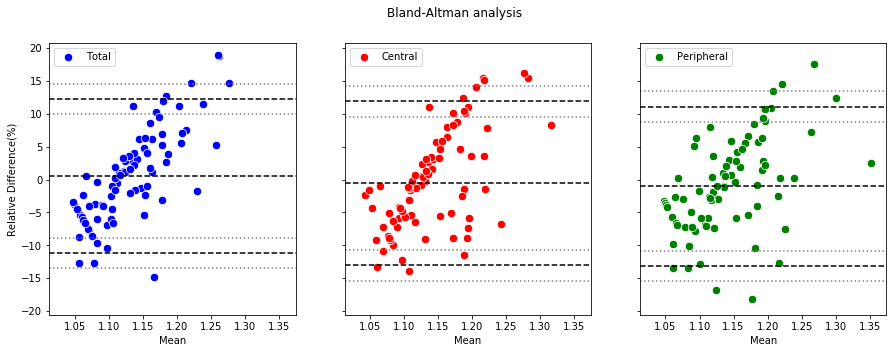

In [321]:
df = pd.read_csv("data/data2.csv", encoding="shift-jis").rename(columns={"baPWV": "Actual baPWV"})
true_col = "Actual baPWV"
pred_col = "Predicted baPWV"

areas = ["Total", "Central", "Peripheral"]
mark_colors = ["blue", "red", "green"]

f, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))


for i, area in enumerate(areas):
    R_col = R_col_names[area]
    L_col = L_col_names[area]
    ba_df = df[[true_col, R_col, L_col]].copy()
    # 予測値はLとRのうち大きいほうを採用
    ba_df[pred_col] = ba_df.apply(lambda x: max(x[L_col], x[R_col]), axis=1)
    # 前処理
    ba_df = Bland_Altman_init(ba_df[[true_col, pred_col]], true_col, pred_col)

    Bland_Altman_plot(ba_df, true_col, pred_col, mark_colors[i], axes[i], True)

    Bland_Altman_result(ba_df)



plt.suptitle("Bland-Altman analysis")
